# Gaussian Fitting for Multiple Lines
We have successfully fit a Gaussian to our lines that only have one peak. However, there are some instances where lines overlap. In order to calculate the brightness for these lines, we must use multiple Gaussian peak fitting.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy.table import Table
import scipy as scipy
from scipy import optimize
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
import matplotlib.ticker as ticker

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
hdulist = fits.open('../data/composite_Io_eclipsed.fits')
evt_data = Table(hdulist[1].data)
image_data = hdulist[1].data
df = pd.read_csv('../data/Io_Master_Line_List (1).csv') #spaces in csv file will make df object type and not float64
line = "S I"
target_mask = df.Species.str.endswith(line) #probably a better function but idk it right now
df = df[target_mask]
df_wavelength = df['Wavelength']
df_species = df['Species']

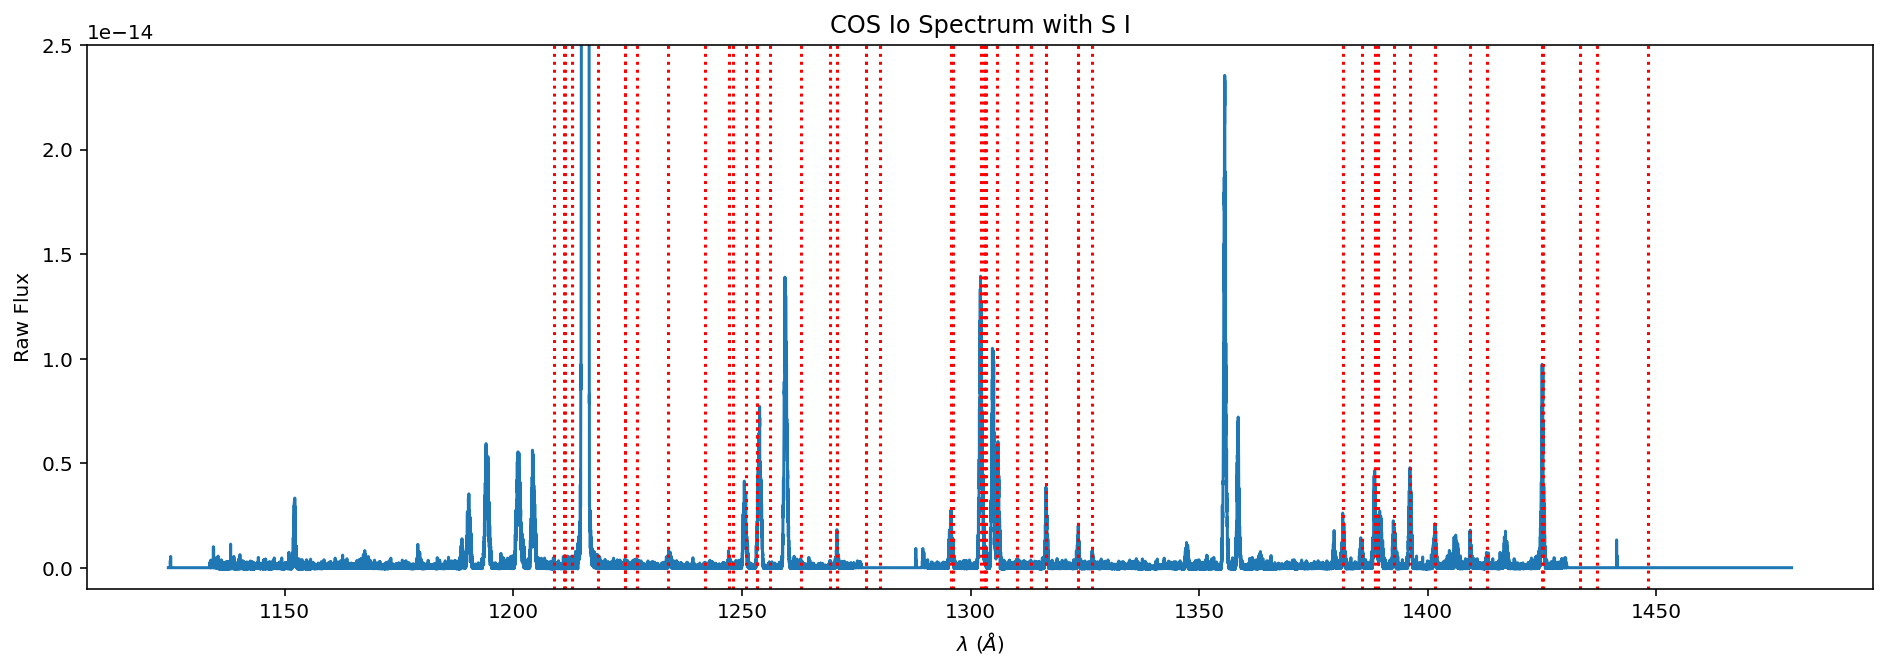

In [3]:
plt.figure(figsize=(16, 5))
plt.plot(evt_data['WAVELENGTH'].T, evt_data['FLUX'].T) #make it columns instead of rows bc otherwise will be a blank plot
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.title("COS Io Spectrum with S I")
plt.ylim(-0.01*10**-13,0.25*10**-13)
for xc in df_wavelength:
    plt.axvline(x=xc, color = 'red', linestyle = 'dotted')

Instead of having one line, we now have two. I have handpicked a portion of the spectrum where the two Gaussians overlap.

(-5e-16, 1.5e-14)

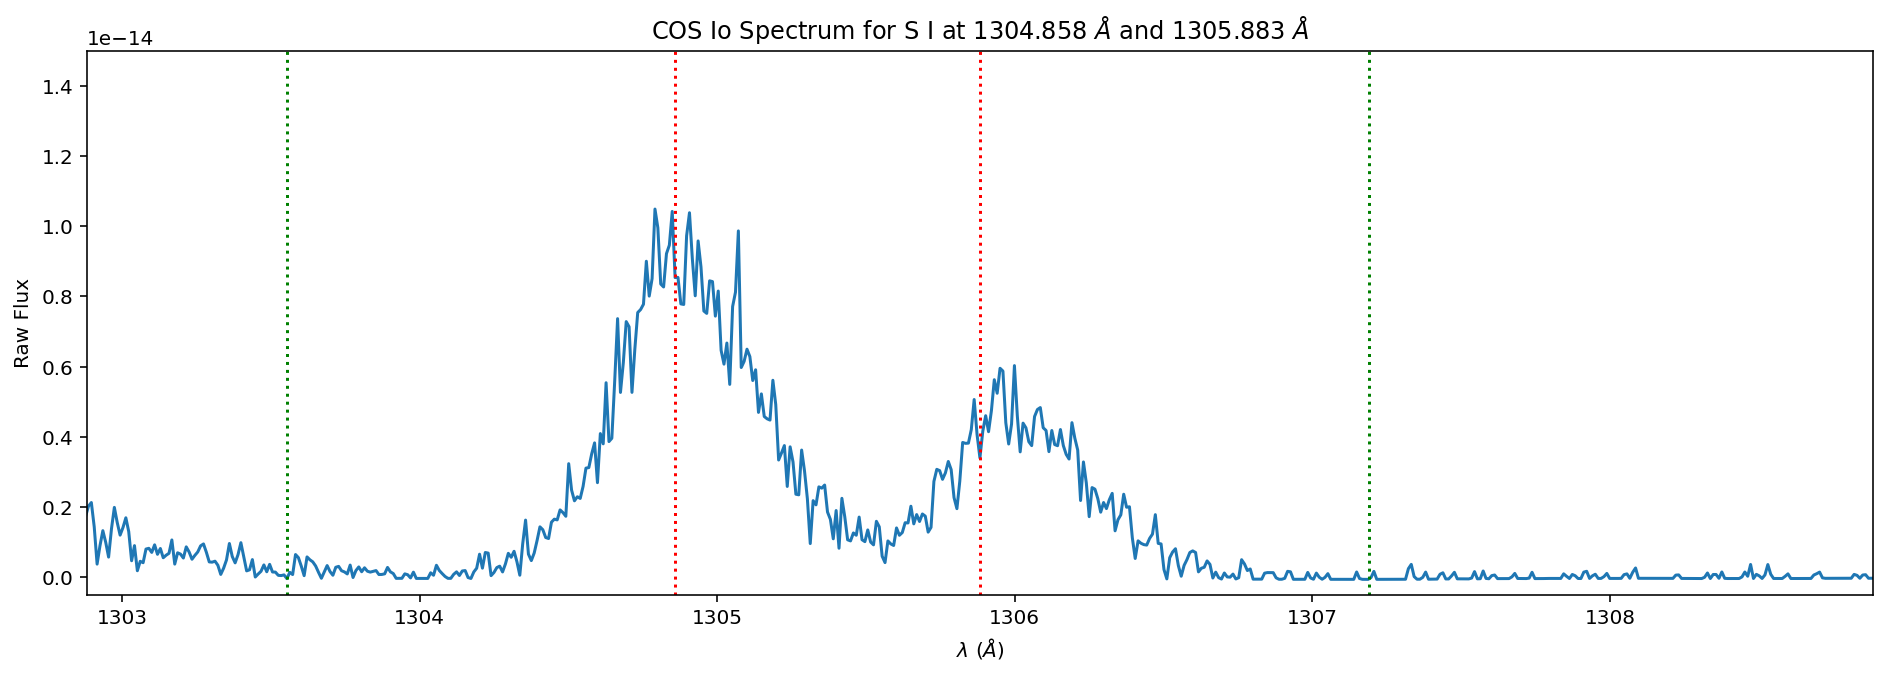

In [55]:
line_1 = 1305.883
line_2 = 1304.858
left_bound = 0.999*line_2
right_bound = 1.001*line_1
plt.figure(figsize=(16, 5))
plt.plot(evt_data['WAVELENGTH'].T, evt_data['FLUX'].T) #make it columns instead of rows bc otherwise will be a blank plot
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.title("COS Io Spectrum for S I at {} $\AA$ and {} $\AA$".format(line_2,line_1))
plt.axvline(line_2, color = 'red', linestyle = 'dotted')
plt.axvline(line_1, color = 'red', linestyle = 'dotted')
plt.axvline(left_bound, color = 'green', linestyle = 'dotted')
plt.axvline(right_bound, color = 'green', linestyle = 'dotted')
plt.xlim(line-3,line+3)
plt.ylim(-0.005*10**-13,0.15*10**-13)

In [52]:
sub_region = (evt_data['WAVELENGTH'] > left_bound) & (evt_data['WAVELENGTH'] < right_bound) #only take values within this area
wl = evt_data['WAVELENGTH'][sub_region]
flux = evt_data['FLUX'][sub_region]
unc = 0.1*flux #placeholder uncertainty
wl_array = wl.data
flux_array = flux.data

(-5e-16, 1.5e-14)

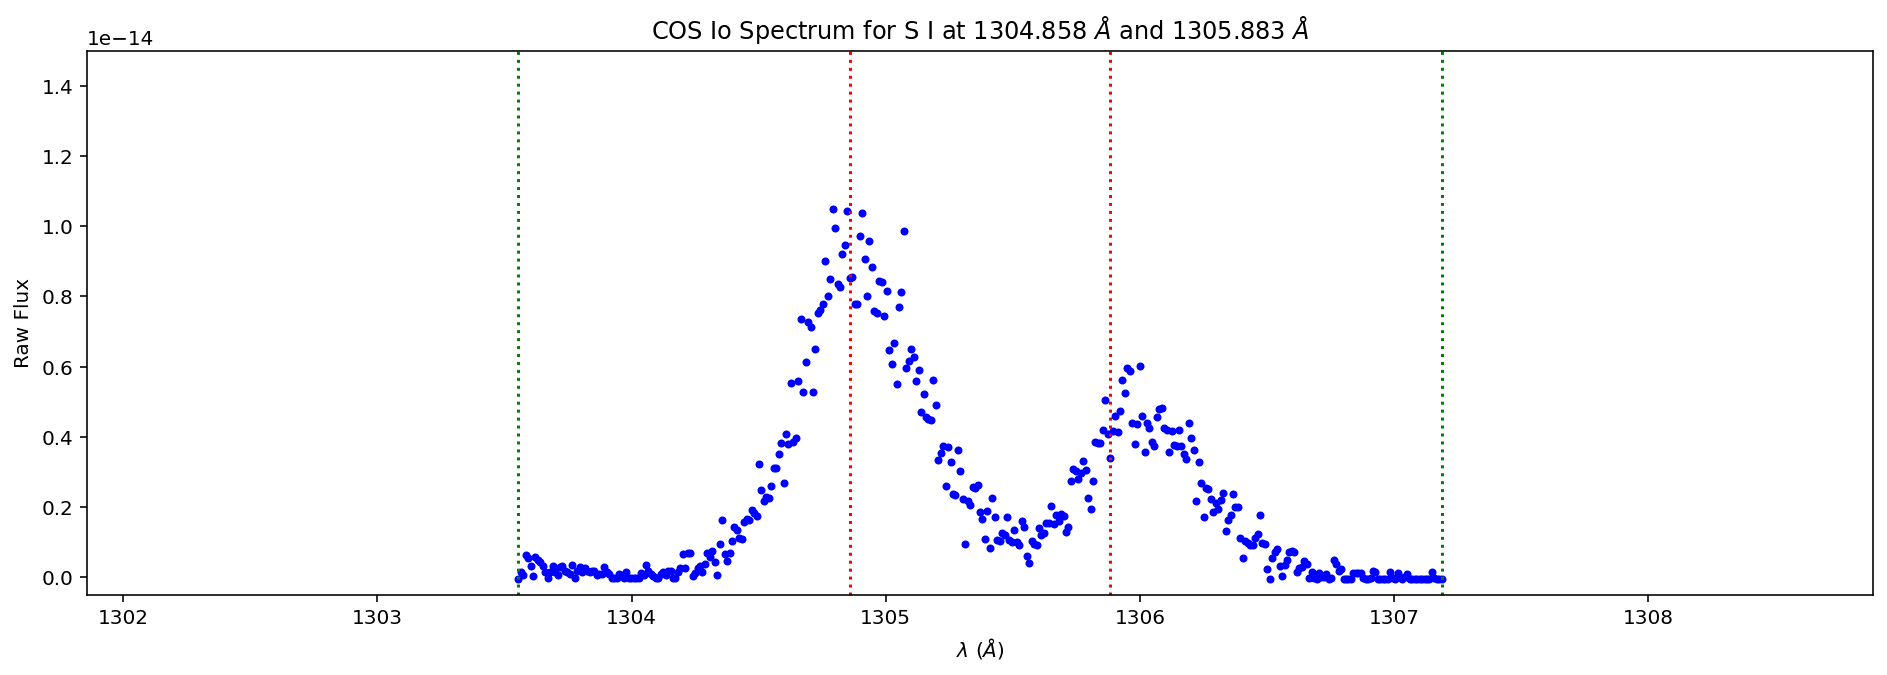

In [54]:
plt.figure(figsize=(16, 5))
plt.plot(wl_array,flux_array,'b.') #make it columns instead of rows bc otherwise will be a blank plot
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.title("COS Io Spectrum for S I at {} $\AA$ and {} $\AA$".format(line_2,line_1))
plt.axvline(line_1, color = 'red', linestyle = 'dotted')
plt.axvline(line_2, color = 'red', linestyle = 'dotted')
plt.axvline(left_bound, color = 'green', linestyle = 'dotted')
plt.axvline(right_bound, color = 'green', linestyle = 'dotted')
plt.xlim(line_2-3,line_1+3)
plt.ylim(-0.005*10**-13,0.15*10**-13)

Now let's define the Gaussian functions for the first line and the second line.

In [56]:
def _1gaussian(x, amp1,cen1,sigma1):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((wl_array-cen1)/sigma1)**2)))

In [57]:
def _2gaussian(x, amp1,cen1,sigma1, amp2,cen2,sigma2):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((wl_array-cen1)/sigma1)**2))) + \
            amp2*(1/(sigma2*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((wl_array-cen2)/sigma2)**2)))

With these functions, we can define guesses for the amplitude, width, and center wavelength.

In [58]:
amp1 = 1*10**-14
sigma1 = 1
cen1 = line_1

amp2 = 1*10**-14
sigma2 = 1
cen2 = line_2

In [59]:
popt_2gauss, pcov_2gauss = scipy.optimize.curve_fit(_2gaussian, wl_array, flux_array, p0=[amp1, cen1, sigma1, amp2, cen2, sigma2])
perr_2gauss = np.sqrt(np.diag(pcov_2gauss))

In [60]:
pars_1 = popt_2gauss[0:3]
pars_2 = popt_2gauss[3:6]
gauss_peak_1 = _1gaussian(wl_array, *pars_1)
gauss_peak_2 = _1gaussian(wl_array, *pars_2)

In [78]:
a1 = popt_2gauss[0]
a1_err = perr_2gauss[0]
mu1 = popt_2gauss[1]
mu1_err = perr_2gauss[1]
w1 = popt_2gauss[2]
w1_err = perr_2gauss[2]

a2 = popt_2gauss[3]
a2_err = perr_2gauss[3]
mu2 = popt_2gauss[4]
mu2_err = perr_2gauss[4]
w2 = popt_2gauss[5]
w2_err = perr_2gauss[5]

In [88]:
print("amplitude_1 = {} (+/-) {}".format("{:e}".format(a1), "{:e}".format(a1_err)))
print("mu_1 = {} (+/-) {}".format(mu1, "{:e}".format(mu1_err)))
print("sigma_1 = {} (+/-) {}".format((w1), "{:e}".format(w1_err)))

print("\namplitude_2 = {} (+/-) {}".format("{:e}".format(a2), "{:e}".format(a2_err)))
print("mu_2 = {} (+/-) {}".format(mu2, "{:e}".format(mu2_err)))
print("sigma_2 = {} (+/-) {}".format((w2), "{:e}".format(w2_err)))

amplitude_1 = 2.850078e-15 (+/-) 6.291255e-17
mu_1 = 1306.005163397977 (+/-) 6.200223e-03
sigma_1 = 0.24485297254080227 (+/-) 6.312200e-03

amplitude_2 = 5.427294e-15 (+/-) 6.242913e-17
mu_2 = 1304.896740050405 (+/-) 3.181249e-03
sigma_2 = 0.24107921491245551 (+/-) 3.237675e-03


Now, let's save the amplitude, center wavelength, and width for each Gaussian.

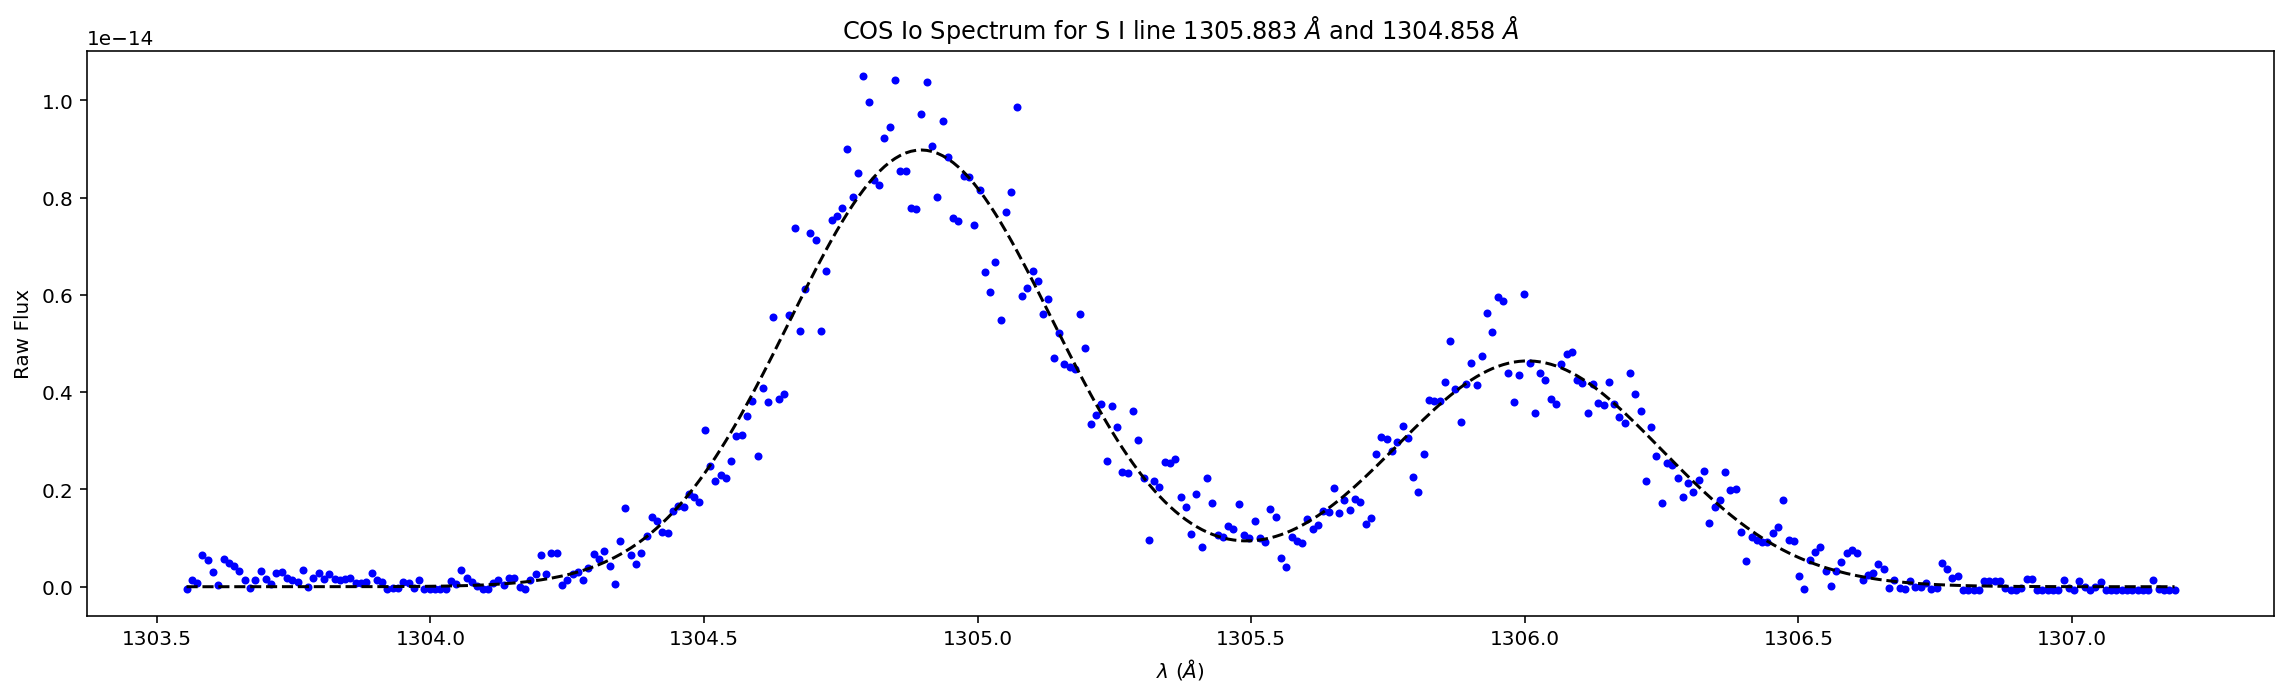

In [66]:
plt.figure(figsize=(16, 5))
plt.plot(wl_array,flux_array,'b.') #make it columns instead of rows bc otherwise will be a blank plot
plt.plot(wl_array, _2gaussian(wl_array, *popt_2gauss), 'k--')
#plt.plot(wl_array, _1gaussian(wl_array, *popt_gauss), 'k--')#,\
#label="y= %0.2f$e^{%0.2fx}$ + %0.2f" % (popt_exponential[0], popt_exponential[1], popt_exponential[2]))
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.title("COS Io Spectrum for S I line {} $\AA$ and {} $\AA$".format(line_1,line_2))
plt.tight_layout()
save_place = '/Users/jojoa/GitHub/io_brightness/data/figures/'
plt.savefig(save_place+"gauss_mult_fit_{}_{}.jpg".format(line_1,line_2), format="jpg",dpi=1000)

In [67]:
brightness_1 = ((2*np.pi)**.5)*(a1*w1)
print("The brightness of S I at {} Angstrom is {}.".format(line_1,brightness_1))

The brightness of S I at 1305.883 Angstrom is 1.7492509322143704e-15.


In [68]:
brightness_2 = ((2*np.pi)**.5)*(a2*w2)
print("The brightness of S I at {} Angstrom is {}.".format(line_2,brightness_2))

The brightness of S I at 1304.858 Angstrom is 3.2796916809947315e-15.


In [76]:
scientific_notation = "{:e}".format(a1)
print(scientific_notation)

2.850078e-15
